In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import time
import xgboost as xgb
from xgboost import DMatrix
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
### reading and sampling the data

def read_file(path):
    """
    reads the file in pandas df and converts the date_time column to datetime type
    """
    df = pd.read_csv(path)
    df['date_time'] = pd.to_datetime(df['date_time'])
    return df

def sample_on_srch_id(df, frac = 0.1):
    """
    samples the dataframe based on the fraction of srach_id
    """
    # get unique srch_ids
    srch_ids = np.unique(df.srch_id)
    # calculate how many ids to return
    chosen_k = int(len(srch_ids) * frac)
    # sample ids
    chosen_ids = random.sample(list(srch_ids), k = chosen_k)
    # filter the df to only have sampled ids
    return df[df['srch_id'].isin(chosen_ids)]

### Feature Engineering --------------------------

## missing data ----------------------------------

def remove_missing_values(df):
    """
    removes columns with more than 50 percent missing data
    """
    missing_values = df.isna().mean().round(4) * 100
    missing_values = pd.DataFrame(missing_values).reset_index()
    missing_values.columns = ["column", "missing"]
    # filter where there are missing values
    missing_values.query("missing > 50", inplace=True)  # remove columns with more than 50 % of missing values
    missing_values.sort_values("missing", inplace=True)
    #print(missing_values)
    df.drop(missing_values.column, axis=1, inplace=True)

def replace_missing_values(df):
    """
    imputes missing values with -1
    """
    df.fillna(value=-1, inplace=True) 

## new features ----------------------------------

def extract_time(df):
    """ 
    month, week, day of the week and hour of search
    """
    df_datetime = pd.DatetimeIndex(df.date_time)
    df["month"] = df_datetime.month
    df["week"] = df_datetime.week
    df["day"] = df_datetime.dayofweek + 1
    df["hour"] = df_datetime.hour
    del df['date_time']

def new_historical_price(df):
    """
    'unlogs' prop_log_historical_price column
    """
    df["prop_historical_price"] = (np.e ** df.prop_log_historical_price).replace(1.0, 0)
    df.drop("prop_log_historical_price", axis=1, inplace=True)

def add_price_position(df, rank_type = "dense"):
    """
    adds hotel price position ("price_position") inside "srch_id" column
    """
    ranks = df.groupby('srch_id')['price_usd'].rank(ascending=True, method = rank_type)
    df["price_position"] = ranks


def average_numerical_features(df, group_by = ["prop_id"], columns = ["prop_starrating", "prop_review_score", "prop_location_score1", "prop_location_score2"]):
    """
    adds mean, median and standard deviation per prop_id (default) 
    for columns that are related to property (default)
    """
    # caulcate means and rename columns
    means = df.groupby(group_by)[columns].mean().reset_index()
    means.columns = [means.columns[0]] + [x + "_mean" for x in means.columns[1:]]
    # caulcate median and rename columns
    medians = df.groupby(group_by)[columns].median().reset_index()
    medians.columns = [medians.columns[0]] + [x + "_median" for x in medians.columns[1:]]
    # caulcate means and rename columns
    stds = df.groupby(group_by)[columns].std().reset_index()
    stds.columns = [stds.columns[0]] + [x + "_std" for x in stds.columns[1:]]
    ## attach aggregated data to the df
    df = pd.merge(df, means, on=group_by)
    df = pd.merge(df, medians, on=group_by)
    df = pd.merge(df, stds, on=group_by)
    return df

def add_historical_booking_click(df):
    """
    creates a column with the percentage of the prop_id booked/clicked rate overall
    """
    # there are more prop_id in the test data than in train. 
    # Maybe we could still use this but would need to impute
    # with the most common value (or something else)
    
    historical = df.groupby("prop_id")[["click_bool", "booking_bool"]].mean().reset_index()
    historical.columns = [historical.columns[0]] + [x + "_rate" for x in historical.columns[1:]]
    df = pd.merge(df, historical, on="prop_id")
    df.sort_values("srch_id", inplace = True)
    return df

def join_historical_data(df, path = "hist_click_book.csv"):
    """
    joins historical data according to prop_id. 
    path - location of historical data csv file
    
    """
    to_join = pd.read_csv(path)
    joined = pd.merge(df, to_join, on="prop_id")
    return joined.sort_values("srch_id")
    
    
## other ----------------------------------

def remove_cols(df, cols = ["position", "prop_id"]):
    df.drop(cols, axis=1, inplace=True)

def remove_positions(df, positions = [5, 11, 17, 23]):
    """
    removes hotels with specified positions 
    (based on the fact that hotels in those positions were not as booked)
    """
    df = df[df["position"].isin(positions) == False]

def add_score(df):
    
    """
    adds 'score' column to the df: 5 for booked, 1 for clicked
    """
    
    score = []
    for book, click in zip(df.booking_bool, df.click_bool):
        if book == 1:
            score.append(5)
            continue
        if click == 1:
            score.append(1)
            continue
        else:
            score.append(0)
    df["score"] = score
    del df['booking_bool']
    del df['click_bool']

def onehot(df, cols):
    """ 
    returns a df with one-hot encoded columns (cols)
    """
    
    return pd.get_dummies(df, columns=cols)

def sampling(df, target, method="undersampling", frac=0.1):
    
    """
    df: input dataframe
    target: target column of majority class
    method: specifies method of sampling - 'undersampling' or 'combination' of undersampling and oversampling.
    frac: final fraction minority wrt majority class (default fraction 0.1/0.9)
    
    returns: df with undersampled majority class
    
    note that this only has to be performed on the training data!
    
    """
    
    # Split df in minority and majority
    minority = df.loc[df[target] > 0]
    majority = df.loc[df[target] == 0]
    lenmin = len(minority)
    lenmaj = len(majority)
    
    # Calculate current fraction
    frac_min = lenmin/(lenmin+lenmaj)
    frac_maj = 1-frac_min
    print(f"Current fraction:\nMinority class: {frac_min}, Majority class: {frac_maj}")
    
    if method == "undersampling":
        
        sampling_frac = ((1-frac)/frac*lenmin)/lenmaj
        sampled_df = df.groupby('srch_id').sample(frac=sampling_frac)
        fin_frac = lenmin / (len(sampled_df) + lenmin)

    elif method == "combination":
        
        # This still needs to be implemented
        
        return
    else:
        raise ExceptionError("Invalid argument for 'method'")
        
    
    print(f"Final fraction:\nMinority class: {fin_frac}, Majority class: {1-fin_frac}")
    
    dfs = [minority, sampled_df]
    finaldf = pd.concat(dfs)
    finaldf.sort_values("srch_id", inplace = True)
    finaldf = finaldf.reset_index(drop=True)

    print("Done")
    return finaldf


### Feature engineering function -----------

def feature_engineering_train(df):
    
    extract_time(df)
    remove_missing_values(df)
    replace_missing_values(df)
    new_historical_price(df)
    add_price_position(df)
#     df = average_numerical_features(df)
#     df = add_historical_booking_click(df)
    add_score(df)
    #remove_cols(df)
    return df

def feature_engineering_test(df):
    
    extract_time(df)
    remove_missing_values(df)
    replace_missing_values(df)
    new_historical_price(df)
    add_price_position(df)
#     df = average_numerical_features(df)
#     df = join_historical_data(df, path="data/hist_click_book.csv")
    return df
    
def create_df_queries_freq(df):
    df_queries = pd.DataFrame()
    df_queries = pd.crosstab(index=df['srch_id'], columns='count', colnames=['srch_id'])
    df_queries.head()
    df_queries.to_csv("../df_queries.csv")
    return pd.read_csv("../df_queries.csv")

In [3]:
df = pd.read_csv("data/training_set_VU_DM.csv")
testset = pd.read_csv("data/test_set_VU_DM.csv")

In [4]:
# add historical bookings to test and trainingset

df = feature_engineering_train(df)
testset = feature_engineering_test(testset)

<ipython-input-2-df06580dc69a>:55: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["week"] = df_datetime.week


In [5]:
# check
df.head()

,srch_id,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,...,srch_saturday_night_bool,orig_destination_distance,random_bool,month,week,day,hour,prop_historical_price,price_position,score
0,1,12,187,219,893,3,3.5,1,2.83,0.0438,...,1,-1.0,1,4,14,4,8,141.174964,3.0,0
1,1,12,187,219,10404,4,4.0,1,2.20,0.0149,...,1,-1.0,1,4,14,4,8,152.933013,14.0,0
2,1,12,187,219,21315,3,4.5,1,2.20,0.0245,...,1,-1.0,1,4,14,4,8,137.002613,15.0,0
3,1,12,187,219,27348,2,4.0,1,2.83,0.0125,...,1,-1.0,1,4,14,4,8,80.640419,22.0,0
4,1,12,187,219,29604,4,3.5,1,2.64,0.1241,...,1,-1.0,1,4,14,4,8,138.379512,11.0,0


In [6]:
# start = time.time()
# df = sampling(df, "score", method="undersampling", frac=0.4)
# end = time.time()

# print(f"Execution took {end-start:.2f} seconds")

In [7]:
# save properties
properties = testset['prop_id']

# delete 

del df['prop_id']
del df['position']
del testset['prop_id']

In [8]:
# trainingset (df) should have 1 column more; the target column score

print(len(testset.columns), len(df.columns))
print(set(df.columns)-set(testset.columns))

26 27
{'score'}


### RandomForest Model

In [9]:
RF = "False"
weight = 1

In [10]:
# prepare data for RF

if RF == "True":
    rf_df = df.copy()
    y_rf_df = df["score"]
    del rf_df["srch_id"]
    del rf_df["score"]
    rf_testset = testset.copy()
    del rf_testset["srch_id"]

In [11]:
# Using sklearn RandomForest Package

if RF == "True":
    clf = RandomForestClassifier(n_estimators=45)
    clf.fit(rf_df, y_rf_df)
    
    # Predict Probabilities with RF
    y_pred = clf.predict_proba(rf_testset)

    # Predicted probabilities
    pp = [item[1] for item in y_pred]

### XGboost

In [12]:
X_train = df.loc[:, ~df.columns.isin(['srch_id','score'])]
y_train = df.loc[:, df.columns.isin(['score'])]

In [13]:
groups = df.groupby('srch_id').size().to_frame('size')['size'].to_numpy()

In [14]:
# learning rate to 0.1
# max_depth 10
# n_estimators
# with the hist thing.

model = xgb.XGBRanker(  
    tree_method='hist',
    booster='gbtree',
    objective='rank:ndcg',
    random_state=42, 
    learning_rate=0.05,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=500, 
    subsample=0.75,
    )

model.fit(X_train, y_train, group=groups, verbose=True)

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.9, eta=0.05, gamma=0,
          gpu_id=-1, importance_type='gain', interaction_constraints='',
          learning_rate=0.05, max_delta_step=0, max_depth=6, min_child_weight=1,
          missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=8,
          num_parallel_tree=1, objective='rank:ndcg', random_state=42,
          reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.75,
          tree_method='hist', validate_parameters=1, verbosity=None)

In [15]:
def predict(model, df):
    return model.predict(df.loc[:, ~df.columns.isin(['srch_id'])])

In [16]:
# this is not necessary right?

del df['score']

In [17]:
predictions = (testset.groupby('srch_id')
               .apply(lambda x: predict(model, x)))

In [18]:
predictions

srch_id
1         [0.100865036, 0.13452753, -0.09258574, -0.3180...
3         [-1.5941745, -0.97082484, -2.3319912, -1.41832...
6         [0.18393375, -0.21946575, 0.60837597, 0.357033...
7         [-2.427657, -0.9810739, -0.40565893, -1.228262...
10        [-1.1566169, -1.3932947, -1.0251939, -1.207583...
                                ...                        
332781    [-0.11588322, -0.843319, -0.04344341, -0.89232...
332783    [-1.5991387, 0.9653507, 0.38500652, -0.5807153...
332785    [1.2128254, -0.8229813, 2.211341, 0.87296814, ...
332786    [0.045388155, 0.39867327, -0.05833867, 1.78658...
332787    [2.502487, 1.4047017, 1.0360335, 2.0632553, -0...
Length: 199549, dtype: object

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

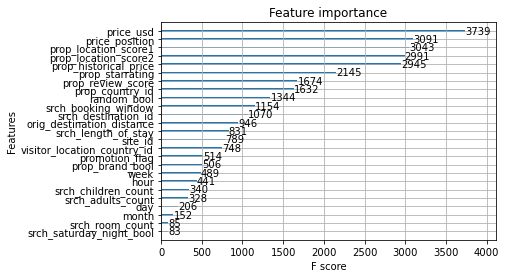

In [19]:
# Most important features

xgb.plot_importance(model)

### Composite RF and LambdaMART score

In [20]:
output = pd.DataFrame()
output["srch_id"] = testset["srch_id"].copy()
output["prop_id"] = properties.copy()

# Add scores
pred_scores_list = []

for i in predictions:
    for j in i:
        pred_scores_list.append(j)
        

if RF == "True":
    output["pred_scores"] = [x + weight*y for x, y in zip(pred_scores_list, pp)]
else:
    output["pred_scores"] = pred_scores_list

In [21]:
# Sort on predicted_score output within srch_id
start = time.time()

out = output.groupby('srch_id').apply(pd.DataFrame.sort_values, 'pred_scores', ascending=False)

end = time.time()
print(f"Execution took {end-start:.2f} seconds")

Execution took 129.44 seconds


In [22]:
del out["pred_scores"]

In [23]:
# write to csv

out.to_csv('data/16052021-2.csv', index=False)

In [24]:
# old = pd.read_csv('data/16052021-1.csv')